In [100]:
import pandas as pd
#import modin.pandas as pd
import numpy as np
import matplotlib
import os
import glob
import math
#import shapefile as shp
import re
import copy
from pyecharts.render import make_snapshot
#from snapshot_selenium import snapshot
#from selenium import webdriver
#from webdriver_manager.chrome import ChromeDriverManager
#from snapshot_selenium import snapshot as driver
from pyecharts import options as opts
from pyecharts.charts import Bar
from pyecharts.render import make_snapshot
# driver = webdriver.Chrome(executable_path='C:/Python38/Scripts/chromedriver.exe')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import threading
from concurrent.futures import ThreadPoolExecutor
from collections import deque
from datetime import *

In [101]:
# only a temporary path
import os
path = '/root/CSC440_project/data_general'
path

'/root/CSC440_project/data_general'

In [22]:
def findfiles(path):
    return glob.glob(path)
working_directory = '/root/CSC440_project/data_general/tweets/*/'
tweets_path_list = findfiles(working_directory)
tweets_list = os.listdir('/root/CSC440_project/data_general/tweets')

In [12]:
# read location csv
location_to_join = pd.read_csv('/root/CSC440_project/data_general/locations_combined.csv', header = None, names = ['id','location'])

In [13]:
# convert all read id into string format
location_to_join['id'] = [str(i) for i in location_to_join['id']]
location_to_join

,id,location
0,5711341129,其他
1,7412051152,其他
2,7568601498,其他
3,1804028250,广东 广州
4,7448767160,四川
...,...,...
574395,6090644549,北京
574396,5940170360,其他
574397,3949398197,山西 晋中
574398,5266395467,山西 吕梁


In [23]:
# read users file
users = pd.read_csv(path+'/combined.csv')
#users = users.drop(users.index[1028030])

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
# rename and select all focused columns
users = users.rename(columns={'用户id':'id','性别': 'gender','微博数':'#tweets', '粉丝数': '#follower', '关注数': '#following','是否认证':'verified'})
users = users[['id','gender','#tweets','#follower','#following','verified']]
users = users.drop_duplicates()
users['id'] = [str(i) for i in users['id']]

In [26]:
users

,id,gender,#tweets,#follower,#following,verified
0,6309921628,f,2902,344,403,False
1,6007931743,m,11,20,163,False
2,7471743898,m,5,10,265,False
3,5701747600,f,3175,95113,1052,False
4,7577162125,m,25,3,190,False
...,...,...,...,...,...,...
1028024,7448723682,m,0,1,214,False
1028025,5343183078,m,418,148,336,False
1028026,7645855842,m,21,1,22,False
1028027,6031048952,f,183,1,1116,False


In [27]:
user_id_lst = location_to_join['id']

In [28]:
# for the user table, add a new column that records whether he/she has actuially post weibo or not
users['content'] = np.zeros(len(users))
users.loc[users['id'].isin(user_id_lst), 'content'] = 1  


In [29]:
users

,id,gender,#tweets,#follower,#following,verified,content
0,6309921628,f,2902,344,403,False,1.0
1,6007931743,m,11,20,163,False,1.0
2,7471743898,m,5,10,265,False,1.0
3,5701747600,f,3175,95113,1052,False,1.0
4,7577162125,m,25,3,190,False,1.0
...,...,...,...,...,...,...,...
1028024,7448723682,m,0,1,214,False,0.0
1028025,5343183078,m,418,148,336,False,1.0
1028026,7645855842,m,21,1,22,False,0.0
1028027,6031048952,f,183,1,1116,False,1.0


# CAUTION!!

In [30]:
with open('total_user.pkl','wb') as f:
    pickle.dump(users,f)

In [31]:
# merge two data frames
users_with_location = users.merge(location_to_join, how='inner', left_on='id', right_on='id')

In [32]:
# futher drop users 
users_with_content = users_with_location.drop_duplicates('id')
users_with_content = users_with_content.reset_index(drop=True)
users_with_content

,id,gender,#tweets,#follower,#following,verified,content,location
0,6309921628,f,2902,344,403,False,1.0,河南 许昌
1,6007931743,m,11,20,163,False,1.0,江苏 南京
2,7471743898,m,5,10,265,False,1.0,其他
3,5701747600,f,3175,95113,1052,False,1.0,上海 杨浦
4,7577162125,m,25,3,190,False,1.0,山东 济南
...,...,...,...,...,...,...,...,...
574352,6505005302,f,36,21,239,False,1.0,其他
574353,1803190527,f,6243,1409,2069,False,1.0,浙江
574354,5343183078,m,418,148,336,False,1.0,北京 海淀
574355,6031048952,f,183,1,1116,False,1.0,海南 海口


# find and record the censored content, along with a counter on each user

In [31]:
class ConcurrentTweetsConfigList:
    __progress_bar = None
    """
    Helper class for managing list that supports asynchronously getting next user config.
    """

    def __init__(self, tweets_path_list):
        self.__tweets_path_list = tweets_path_list
        #self.__lock = threading.Lock()
        self.__iterator = iter(tweets_path_list)
        if ConcurrentTweetsConfigList.__progress_bar is None:
            ConcurrentTweetsConfigList.__progress_bar = tqdm(desc="#posts", unit="posts", total=len(self), position=0)
            ConcurrentTweetsConfigList.__progress_bar.display()

    def __next__(self):
        #with self.__lock:
        out = next(self.__iterator)
        ConcurrentTweetsConfigList.__progress_bar.update()
        return out

    def __iter__(self):
        """Each iterator will only point to self. This ensures each thread is iterating on the same iterator. """
        return self

    def __len__(self):
        return len(self.__tweets_path_list)

In [103]:
rename_dict = {
    '视频url': 'reposter_device',  
    '原始图片url': 'reposting_time', 
    '位置': '#likes', 
    '日期': '#comments', 
    '工具': '#reposts', 
    '点赞数': 'repost_weibo_comment',
    '源用户id': 'source_user_id', 
    '源用户昵称': 'source_user_nickname', 
    '源微博原始图片url': 'source_weibo_post_time',
    '源微博视频url': 'source_weibo_device', 
    '源微博位置': '#source_weibo_likes', 
    '源微博日期': '#source_weibo_comments', 
    '源微博工具': '#source_weibo_reposts', 
    '源微博点赞数': 'source_weibo_content' 
}

rename_dict2 = {
    "正文": 'repost_weibo_comment',
    '日期': 'reposting_time',
    '工具': 'reposter_device',
    '点赞数': '#likes',
    '评论数':'#comments',
    '转发数': '#reposts',
    '源用户id': 'source_user_id',
    '源用户昵称': 'source_user_nickname',
    '源微博正文': 'source_weibo_content',
    '源微博日期': 'source_weibo_post_time',
    '源微博工具': 'source_weibo_device',
    '源微博点赞数': '#source_weibo_likes',
    '源微博评论数': '#source_weibo_comments',
    '源微博转发数': '#source_weibo_reposts'
    
}

string1 = '抱歉，由于作者设置，'
string2 = '该微博因被多人投诉'
string3 = '该账号因被投诉违反'
string4 = '该账号因被投诉'
string5 = '查看帮助： 网页链接'

censor_indications = [string1, string2, string2, string4, string5]

# resumption from break point?
def tweets_tackling(tweets_list, segment_index):
    censored_repost_list = deque()
    # /data_general/tweets/用户名/user_id.csv
    # count the number of censored reposts for each user
    # put then-censored reposts into one pandas dataframe
    
    for i in tqdm(tweets_list, desc="#posts", unit="posts", total=len(tweets_list), position=0):
        try:
            weibo_ = findfiles(i + '/*.csv')[0]
            id_ = os.path.splitext(os.path.basename(os.listdir(i)[0]))[0]
            user_weibo_df = pd.read_csv(weibo_)
            try:
                datetime.strptime(user_weibo_df['原始图片url'][0],'%a %b %d %X %z %Y')
                # needs rename
                user_weibo_df = user_weibo_df.drop(columns=['bid','id','正文','头条文章url','源微博@用户','源微博话题','源微博转发数', '源微博bid','源微博id','源微博正文', '源微博头条文章url','评论数', '转发数', '话题', '@用户', '是否原创','源微博评论数']).rename(columns=rename_dict)
                user_weibo_df = user_weibo_df.assign(
                    user_id = id_,
                    is_censored_repost = user_weibo_df['source_weibo_content'].map(lambda content: any((keyword in str(content) for keyword in censor_indications)))
                )
            except TypeError:
                user_weibo_df = user_weibo_df.drop(columns=['id','bid','头条文章url','原始图片url','视频url','源微博视频url','源微博位置','是否原创','源微博bid','话题','@用户','源微博@用户','位置','源微博id','源微博头条文章url','源微博原始图片url','源微博话题']).rename(columns=rename_dict2)
                user_weibo_df = user_weibo_df.assign(
                    user_id = id_,
                    is_censored_repost = user_weibo_df['source_weibo_content'].map(lambda content: any((keyword in str(content) for keyword in censor_indications)))
                )
            censored_repost_list.extend((row for _, row in user_weibo_df.iterrows()))
        except IndexError:
            print(i)

#     with open('__user_censornumber_%s.pkl' %thread_num , 'wb') as f:
#         pickle.dump(user_censornumber, f)

#     with open('__user_tweetsnumber_%s.pkl' %thread_num, 'wb') as f:
#         pickle.dump(user_tweetsnumber, f)
    censored_repost_df = pd.DataFrame(list(censored_repost_list))
    
    with open('__raw_repost_df_%s.pkl' % segment_index, 'wb') as f:
        pickle.dump(censored_repost_df,f)

In [92]:
def main():
    segment_length = 50000
    for i in range(len(tweets_path_list)//segment_length + 1):
        path_segment = tweets_path_list[i*segment_length: (i+1)*segment_length]
        tweets_tackling(path_segment, segment_index)
#     with ThreadPoolExecutor(max_workers=6) as executor:
#         for i in range(6):
#             executor.submit(censored_tackling, concurrent_tweets_list, i)

In [ ]:
main()

In [105]:
test_df.head()

,reposting_time,reposter_device,#likes,#comments,#reposts,repost_weibo_comment,source_user_id,source_user_nickname,source_weibo_post_time,source_weibo_device,#source_weibo_likes,#source_weibo_comments,#source_weibo_reposts,source_weibo_content,user_id,is_censored_repost
0,Sun Aug 01 03:41:33 +0800 2021,iPhone客户端,1,0.0,0.0,转发微博,6.804337e+09,oneneedless,Tue Jul 13 22:00:00 +0800 2021,iPhone客户端,105,3,48.0,该分享给谁呢 我今天经历的事 我此时此刻正在做的事 我看到的风景 我的单曲循环 我的难过 我...,5711341129,False
1,Sun Dec 27 22:39:03 +0800 2020,iPhone客户端,0,0.0,0.0,//@廿一几:转发微博,3.674428e+09,obliviuforu,Sun Dec 27 22:31:34 +0800 2020,NaN,1077,24,94.0,什么都不敢抱太大的希望 这是阴影也是教训,5711341129,False
2,Sun May 24 09:08:34 +0800 2020,iPhone客户端,3,0.0,0.0,转发微博,1.719233e+09,那英,Fri Aug 26 03:01:32 +0800 2011,iPad客户端,117079,26148,96958.0,妈的，最烦装逼的人！,5711341129,False
0,Mon Aug 02 15:54:07 +0800 2021,vivo 全新水滴屏手机,0,0.0,0.0,转发微博,1.407590e+09,复兴生活馆,Sun Aug 01 21:00:03 +0800 2021,微博 weibo.com,8189,473,10078.0,被世界遗忘的角落，只有植物缓缓生长，证明时间的流逝,7412051152,False
1,Mon Aug 02 11:58:25 +0800 2021,vivo 全新水滴屏手机,0,0.0,0.0,转发微博,6.532231e+09,無端Cathyyy,Sun Aug 01 13:12:06 +0800 2021,iPhone客户端,72340,1156,15652.0,可不可以把运动Bra的代言也给女运动员们啊，女明星那些犹穿外套半遮面的照片又看不出来支撑强度...,7412051152,False


In [97]:
test_df[test_df['source_weibo_content'].map(lambda x : type(x) not in [str,float])]

,reposting_time,reposter_device,#likes,#comments,#reposts,repost_weibo_comment,source_user_id,source_user_nickname,source_weibo_post_time,source_weibo_device,#source_weibo_likes,#source_weibo_comments,#source_weibo_reposts,source_weibo_content,user_id,is_censored_repost


In [51]:
pd.read_csv('/root/CSC440_project/data_general/tweets/HuYu-m/5711341129.csv').drop(columns=['bid','id','正文','头条文章url','源微博@用户','源微博话题','源微博转发数', '源微博bid','源微博id','源微博正文', '源微博头条文章url','评论数', '转发数', '话题', '@用户', '是否原创','源微博评论数']).rename(columns=rename_dict)

,reposting_time,reposter_device,#likes,#comments,#reposts,repost_weibo_comment,source_user_id,source_user_nickname,source_weibo_post_time,source_weibo_device,#source_weibo_likes,#source_weibo_comments,#source_weibo_reposts,source_weibo_content
0,Sun Aug 01 03:41:33 +0800 2021,iPhone客户端,1,0,0,转发微博,6804337464,oneneedless,Tue Jul 13 22:00:00 +0800 2021,iPhone客户端,105,3,48,该分享给谁呢 我今天经历的事 我此时此刻正在做的事 我看到的风景 我的单曲循环 我的难过 我...
1,Sun Dec 27 22:39:03 +0800 2020,iPhone客户端,0,0,0,//@廿一几:转发微博,3674428202,obliviuforu,Sun Dec 27 22:31:34 +0800 2020,NaN,1077,24,94,什么都不敢抱太大的希望 这是阴影也是教训
2,Sun May 24 09:08:34 +0800 2020,iPhone客户端,3,0,0,转发微博,1719232542,那英,Fri Aug 26 03:01:32 +0800 2011,iPad客户端,117079,26148,96958,妈的，最烦装逼的人！


In [98]:
len(tweets_path_list) // 11 + 1

52703

# take the original repost content

In [10]:
def raw_repost_tackling(tweets_path_list=tweets_path_list,thread_num=0):
    rename_dict = {
        '视频url': 'reposter_device',  '原始图片url': 'reposting time', '位置': '#likes', '日期': '#comments', '工具': '#reposts', '点赞数': 'repost_weibo_comment','源用户id': 'source_user_id', '源用户昵称': 'source_user_nickname', '源微博视频url': 'source_weibo_device', '源微博位置': '#source_weibo_likes', '源微博日期': '#source_weibo_comments', '源微博工具': 'source_weibo_reposts', '源微博点赞数': 'source_weibo_content' }
    repost_list = []

    for i in tqdm(tweets_path_list):
        weibo_ = findfiles(i + '/*.csv')
        try:
            id_ = os.path.splitext(os.path.basename(os.listdir(i)[0]))[0]
            user_weibo_df = pd.read_csv(weibo_[0]).drop(columns=['bid','id','正文','头条文章url','源微博原始图片url','源微博@用户','源微博话题','源微博转发数', '源微博bid','源微博id','源微博正文', '源微博头条文章url', '源微博原始图片url','评论数', '转发数', '话题', '@用户', '是否原创','源微博评论数']).rename(columns=rename_dict)
            user_weibo_df['user_id'] = [id_ for i in range(user_weibo_df.shape[0])]
            for j in range(user_weibo_df.shape[0]):
                repost_list.append(user_weibo_df.iloc[j])
        except IndexError:
            pass
    repost_df = pd.DataFrame(repost_list,columns=['reposting time', 'reposter_device', '#likes', '#comments', '#reposts',
       'repost_weibo_comment', 'source_user_id', 'source_user_nickname',
       'source_weibo_device', '#source_weibo_likes', '#source_weibo_comments',
       'source_weibo_reposts', 'source_weibo_content','user_id'])
    with open('raw_repost_df_%d.pkl' %thread_num, 'wb') as f:
        pickle.dump(repost_df, f)
    return repost_df

In [11]:
def main1():
    concurrent_tweets_list = ConcurrentTweetsConfigList(tweets_path_list)
    with ThreadPoolExecutor(max_workers=4) as executor:
        for i in range(4):
            executor.submit(raw_repost_tackling, concurrent_tweets_list, i)

In [ ]:
main1()

#users:  37%|███████████████████████████████████                                                           | 215980/579730 [42:31<385:14:27,  3.81s/ppl]

In [28]:
# generate n*50000 df
all_tweets = []
for i in range(len(tweets_path_list)//50000 + 1):
    all_tweets.append(tweets_path_list[i*50000:(i+1)*50000])

In [ ]:
for index, value in enumerate(all_tweets):
    print(index)
    raw_repost_tackling(value, index)

# Combine pickel files

In [36]:
censored_count_dict = {}
user_tweet_number_dict = {}
censored_repost_general_df = pd.DataFrame(columns=['reposting time', 'reposter_device', '#likes', '#comments', '#reposts',
           'repost_weibo_comment', 'source_user_id', 'source_user_nickname',
           'source_weibo_device', '#source_weibo_likes', '#source_weibo_comments',
           'source_weibo_reposts', 'source_weibo_content','user_id'])

for i in range(8):
    # user censorship number dictionary
    with open('./user_censornumber_%d.pkl' %i, 'rb') as f:
        censor_dict = pickle.load(f)
        censored_count_dict = {**censored_count_dict,**censor_dict}
    f.close()
    # user censored repost dataframe
    with open('./censored_repost_df_%d.pkl' %i, 'rb') as f:
        temp_repost_df = pickle.load(f)
        censored_repost_general_df = pd.concat([censored_repost_general_df, temp_repost_df])
    # user total number of tweets dictionary
    with open('./user_tweetsnumber_%d.pkl' %i, 'rb') as f:
        tweets_number_dict = pickle.load(f)
        user_tweet_number_dict = {**user_tweet_number_dict, **tweets_number_dict}


In [15]:
with open('user_censor_number.pkl','wb') as f:
    pickle.dump(censored_count_dict,f)

In [8]:
with open('user_tweets_number.pkl','wb') as f:
    pickle.dump(user_tweet_number_dict,f)

# Take the user censorship count and their content
## We only analyze the number of users whose tweets are greater than 0

In [6]:
# group by users and count their corresponding number of censored repostings
user_censorship_count = pd.DataFrame(censored_repost_general_df.groupby('user_id').size()).reset_index().rename(columns={0:'count'})
user_censorship_count

,user_id,count
0,._1191724082,9
1,._1917338544,1
2,._5658657526,1
3,._5918704696,1
4,1000074972,1
...,...,...
180734,78220968,1
180735,79066777,1
180736,79790970,1
180737,87328568,2


In [7]:
# some strange user_ids, change them into integers
user_censorship_count['user_id'] = user_censorship_count['user_id'].map(lambda x: re.sub('[^0-9]*','',x))

In [8]:
# convert value-pair censorship_count_df to dictionary
user_censorship_dict = user_censorship_count.set_index('user_id').T.to_dict('index')['count']

In [20]:
# record numbers in list
number_of_censorship = []
for i in list(users_with_content['id']):
    if i in user_censorship_dict.keys():
        number_of_censorship.append(user_censorship_dict[i])
    else:
        number_of_censorship.append(0)

In [21]:
# append list to users_with_content
users_with_content['#censoship'] = number_of_censorship

In [25]:
users_with_content

,id,gender,#tweets,#follower,#following,verified,content,location,#censoship
0,6309921628,f,2902,344,403,False,1.0,河南 许昌,0
1,6007931743,m,11,20,163,False,1.0,江苏 南京,0
2,7471743898,m,5,10,265,False,1.0,其他,0
3,5701747600,f,3175,95113,1052,False,1.0,上海 杨浦,0
4,7577162125,m,25,3,190,False,1.0,山东 济南,0
...,...,...,...,...,...,...,...,...,...
574352,6505005302,f,36,21,239,False,1.0,其他,0
574353,1803190527,f,6243,1409,2069,False,1.0,浙江,0
574354,5343183078,m,418,148,336,False,1.0,北京 海淀,1
574355,6031048952,f,183,1,1116,False,1.0,海南 海口,1


In [26]:
# make columns more consistent
users_with_content['#tweets'] = users_with_content['#tweets'].apply(lambda x: int(x))
users_with_content['#follower'] = users_with_content['#follower'].apply(lambda x: int(x))
users_with_content['#following'] = users_with_content['#following'].apply(lambda x: int(x))



In [27]:
users_with_content

,id,gender,#tweets,#follower,#following,verified,content,location,#censoship
0,6309921628,f,2902,344,403,False,1.0,河南 许昌,0
1,6007931743,m,11,20,163,False,1.0,江苏 南京,0
2,7471743898,m,5,10,265,False,1.0,其他,0
3,5701747600,f,3175,95113,1052,False,1.0,上海 杨浦,0
4,7577162125,m,25,3,190,False,1.0,山东 济南,0
...,...,...,...,...,...,...,...,...,...
574352,6505005302,f,36,21,239,False,1.0,其他,0
574353,1803190527,f,6243,1409,2069,False,1.0,浙江,0
574354,5343183078,m,418,148,336,False,1.0,北京 海淀,1
574355,6031048952,f,183,1,1116,False,1.0,海南 海口,1


In [28]:
with open('users_with_content_df.pkl','wb') as f:
    pickle.dump(users_with_content,f)

# plot of #follower

In [41]:
users_with_content['#follower'].describe()

count    5.743570e+05
mean     5.605839e+04
std      1.120576e+06
min      0.000000e+00
25%      1.000000e+01
50%      7.100000e+01
75%      2.600000e+02
max      1.979235e+08
Name: #follower, dtype: float64

In [ ]:
logged_follower = users_with_content['#follower'].apply(lambda x: 0 if x == 0 else np.log(x))
logged_follower

In [ ]:
logged_follower.describe()

In [ ]:
from plotnine import *
logged_follower.plot.density(color='green')

In [ ]:
users['#following'].describe()

In [ ]:
users['#tweets'].describe()

# below are places for descriptive analysis, maybe later I will add mode devices to users_with_content table

In [37]:
censored_repost_general_df 

,reposting time,reposter_device,#likes,#comments,#reposts,repost_weibo_comment,source_user_id,source_user_nickname,source_weibo_device,#source_weibo_likes,#source_weibo_comments,source_weibo_reposts,source_weibo_content,user_id
0,Tue Nov 03 12:48:56 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764
1,Mon Oct 05 08:23:45 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反法律法规和《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764
2,Wed Sep 30 09:20:33 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764
3,Sun Aug 23 08:31:31 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764
4,Sat Aug 22 06:33:15 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69705,Wed Jun 30 13:46:38 +0800 2021,荣耀20 PRO,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,抱歉，由于作者设置，你暂时没有这条微博的查看权限哦。查看帮助： 网页链接,7546832677
69706,Sat Jun 09 07:57:51 +0800 2018,iPhone 8 Plus,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5065578524
69707,Mon Jul 06 08:14:19 +0800 2020,iPhone客户端,0.0,0,0,//@_pumpyumkin:记住了！//@西西里岛岛主金女士:这个真是第一次知道！以后会记...,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5526765973
69708,Fri Apr 10 14:18:18 +0800 2020,iPhone客户端,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5526765973


In [38]:
# generate a more generalised device pandas series for the censored_repost_df
refined_list = []
generalised_device_list = list(censored_repost_general_df['reposter_device'])
for i in range(len(generalised_device_list)):
    # Apple devices
    if type(generalised_device_list[i]) is str:
        if any(x in str(generalised_device_list[i]) for x in ['iPhone','iPad','Mac']):
            refined_list.append('Apple')
        elif any(x in str(generalised_device_list[i]) for x in ['浏览器', '微博']):
            refined_list.append('Web')
        elif any(x in str(generalised_device_list[i]) for x in ['Huawei','nova','华为','HUAWEI','nova','Harmony']):
            refined_list.append('Huawei')
        elif any(x in str(generalised_device_list[i]) for x in ['荣耀']):
            refined_list.append('Honor')
        elif any(x in str(generalised_device_list[i]) for x in ['小米', 'Redmi','红米']):
            refined_list.append('XiaoMi')
        elif any(x in str(generalised_device_list[i]) for x in ['vivo']):
            refined_list.append('vivo')
        elif any(x in str(generalised_device_list[i]) for x in ['OPPO']):
            refined_list.append('OPPO')
        elif any(x in str(generalised_device_list[i]) for x in ['三星','Samsung']):
            refined_list.append('Samsung')
        elif any(x in str(generalised_device_list[i]) for x in ['android','Android']):
            refined_list.append('General Andoid')
        elif any(x in str(generalised_device_list[i]) for x in ['realme','真我']):
            refined_list.append('Realme')
        elif any(x in str(generalised_device_list[i]) for x in ['iQOO']):
            refined_list.append('IQOO')
        elif any(x in str(generalised_device_list[i]) for x in ['一加','OnePlus']):
            refined_list.append('OnePlus')
        else:
            refined_list.append('other')
    else:
        refined_list.append('NaN')

In [39]:
censored_repost_general_df['general_device'] = refined_list 

In [45]:
# the absolute count of devices regarding the censored reposts
censored_repost_general_df.groupby('general_device').size()    

general_device
Apple             184013
General Andoid     29496
Honor              32571
Huawei             81979
IQOO                2136
NaN                13860
OPPO               36391
OnePlus             2799
Realme              1782
Samsung             5996
Web                79729
XiaoMi             37540
other              17266
vivo               32559
dtype: int64

In [40]:
censored_repost_general_df

,reposting time,reposter_device,#likes,#comments,#reposts,repost_weibo_comment,source_user_id,source_user_nickname,source_weibo_device,#source_weibo_likes,#source_weibo_comments,source_weibo_reposts,source_weibo_content,user_id,general_device
0,Tue Nov 03 12:48:56 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
1,Mon Oct 05 08:23:45 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反法律法规和《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
2,Wed Sep 30 09:20:33 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
3,Sun Aug 23 08:31:31 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
4,Sat Aug 22 06:33:15 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69705,Wed Jun 30 13:46:38 +0800 2021,荣耀20 PRO,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,抱歉，由于作者设置，你暂时没有这条微博的查看权限哦。查看帮助： 网页链接,7546832677,Honor
69706,Sat Jun 09 07:57:51 +0800 2018,iPhone 8 Plus,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5065578524,Apple
69707,Mon Jul 06 08:14:19 +0800 2020,iPhone客户端,0.0,0,0,//@_pumpyumkin:记住了！//@西西里岛岛主金女士:这个真是第一次知道！以后会记...,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5526765973,Apple
69708,Fri Apr 10 14:18:18 +0800 2020,iPhone客户端,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5526765973,Apple


In [41]:
with open('censored_repost_general_df.pkl','wb') as f:
    pickle.dump(censored_repost_general_df,f)

# Analysis on texts

In [46]:
censored_repost_general_df 

,reposting time,reposter_device,#likes,#comments,#reposts,repost_weibo_comment,source_user_id,source_user_nickname,source_weibo_device,#source_weibo_likes,#source_weibo_comments,source_weibo_reposts,source_weibo_content,user_id,general_device
0,Tue Nov 03 12:48:56 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
1,Mon Oct 05 08:23:45 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反法律法规和《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
2,Wed Sep 30 09:20:33 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
3,Sun Aug 23 08:31:31 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
4,Sat Aug 22 06:33:15 +0800 2020,华为Mate 9保时捷设计,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,1113092764,Huawei
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69705,Wed Jun 30 13:46:38 +0800 2021,荣耀20 PRO,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,抱歉，由于作者设置，你暂时没有这条微博的查看权限哦。查看帮助： 网页链接,7546832677,Honor
69706,Sat Jun 09 07:57:51 +0800 2018,iPhone 8 Plus,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5065578524,Apple
69707,Mon Jul 06 08:14:19 +0800 2020,iPhone客户端,0.0,0,0,//@_pumpyumkin:记住了！//@西西里岛岛主金女士:这个真是第一次知道！以后会记...,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5526765973,Apple
69708,Fri Apr 10 14:18:18 +0800 2020,iPhone客户端,0.0,0,0,转发微博,NaN,NaN,NaN,0,0,0,该账号因被投诉违反《微博社区公约》的相关规定，现已无法查看。查看帮助 网页链接,5526765973,Apple


# extract sentences and further refine them to compose the corpus

In [47]:
corpus = np.array(censored_repost_general_df['repost_weibo_comment'])
corpus = corpus[~pd.isnull(corpus)]
corpus = [str(i) for i in corpus]
# segregate comments from multiple reposters
corpus_segregated = []
for i in tqdm(corpus):
    split_repost = re.findall(r'(?<=//@).+?(?=/|$)',i)
    if split_repost:
        corpus_segregated += [i[i.find(':')+1:] for i in split_repost]
    else:
        corpus_segregated.append(i)


100%|███████████████████████████████| 548383/548383 [00:00<00:00, 584289.55it/s]


In [48]:
# further clean the corpus_segragated
corpus_segregated = [i for i in corpus_segregated if i] #get rid of empty strings
corpus_segregated = [i for i in corpus_segregated if i != '转发微博' and i != 'repost' and i != '轉發微博' and i != 'Repost'] #take out default wordings


In [49]:
# take out all @
corpus_segregated = list(map(lambda x: re.sub(r'@[\S]+(?=\s|$)', ' ' ,x), corpus_segregated))

In [50]:
corpus_segregated

['解锁“85“惊喜，为“酷盖”盖楼！转赞评三连，锁定  和想妹一起盖楼，8月5号抽一名幸运鹅送 【YOGA故宫文创联名 手提内胆包】 ～还有机会得到王一博定制版平板电脑哦～#一起上场敢想敢搏#',
 '解锁“85“惊喜，为“酷盖”盖楼！转赞评三连，锁定  和想妹一起盖楼，8月5号抽一名幸运鹅送 【YOGA故宫文创联名 手提内胆包】 ～还有机会得到王一博定制版平板电脑哦～#一起上场敢想敢搏#',
 '存档防删',
 '塞塞送了我一瓶，我用了一周之后乖乖来转发…绝了！！！！ 一周用了三天，肤色明显变亮白变干净，而且我这周还经常熬夜。总之就是神奇，现在身边每个人说自己长痘我都推荐这个',
 '真违法犯罪了就承担处罚，有什么好说的，誰他妈要去劫狱啊，吃多了还是还珠格格看多了，沙币才会信这种智障言论吧',
 '我才真的是想问这个世界怎么了，无语子',
 '转转这个！好像还没得到救援！',
 '大概率也很难再看到你活跃于舞台上了。但还是会想要知道你沿途看到了什么风景。这几年你得到了很多也承受了很多，隐退的心思也起了几回，那就这样吧，你还是有很多选择，很多路可走不必耗在这，反正总会走到终点。',
 '情绪一直都挺稳定但难免发了很多没逻辑无意义的废话。你的私生活我从不想去关注置喙，但我有数你是个什么样的人，没有把你放在神坛上。关于这件事也一直在说不会姑息违法犯罪行为，作为一个粉丝也作为一个想保持理智的人，所以会等最后的判决结果。六年了希望你一切都好，在结果出来之前不做任何评论了',
 '因为都女士那些有底气的勇敢发言，所以我心里预判她说的是真的。所以我一直在说她既然声称有足够证据，那法律是她维权的最好途径。你当然可以利用舆论，但在这前提下要你没有谎话。不然舆论会把你架起来，也有可能会反扑你，你操控不了的。',
 '我还是要说，一切属实的话这就是明明白白的违法犯罪，还只是单纯想让他社死退出娱乐圈的，我不同意。都女士说了手上有能把他送进去的证据，再把事情娱乐化那就是在包庇他。',
 '你是不是烂人跟你是不是违法犯罪做了她们口中那些事是两回事。但不管怎样你要为自己的所作所为承担责任',
 '从始至终都在说，我们只等最后的法律陈词。不信谣也不传谣。事实是如何的，他吴亦凡是否有罪该有什么惩罚都是由司法定案，任何网友都没有给他下罪名的权利。',
 '我说相信他，但我也相信法律会有公正的判决，

In [51]:
# take the non-chinese, non-english and non-numeric characters out of the corpus while keeping some normal punctuation marks
pattern = re.compile(r'[^\u4e00-\u9fa5^a-z^A-Z^0-9\u3002\uff1b\uff0c\uff1a\u201c\u201d\uff08\uff09\u3001\uff1f\u300a\u300b]')
corpus_segregated = list(map(lambda x: re.sub(pattern,'',x), corpus_segregated))

In [52]:
# clear the empty strings
corpus_segregated = [i for i in corpus_segregated if i]
corpus_segregated

['解锁“85“惊喜，为“酷盖”盖楼转赞评三连，锁定和想妹一起盖楼，8月5号抽一名幸运鹅送YOGA故宫文创联名手提内胆包还有机会得到王一博定制版平板电脑哦一起上场敢想敢搏',
 '解锁“85“惊喜，为“酷盖”盖楼转赞评三连，锁定和想妹一起盖楼，8月5号抽一名幸运鹅送YOGA故宫文创联名手提内胆包还有机会得到王一博定制版平板电脑哦一起上场敢想敢搏',
 '存档防删',
 '塞塞送了我一瓶，我用了一周之后乖乖来转发绝了一周用了三天，肤色明显变亮白变干净，而且我这周还经常熬夜。总之就是神奇，现在身边每个人说自己长痘我都推荐这个',
 '真违法犯罪了就承担处罚，有什么好说的，誰他妈要去劫狱啊，吃多了还是还珠格格看多了，沙币才会信这种智障言论吧',
 '我才真的是想问这个世界怎么了，无语子',
 '转转这个好像还没得到救援',
 '大概率也很难再看到你活跃于舞台上了。但还是会想要知道你沿途看到了什么风景。这几年你得到了很多也承受了很多，隐退的心思也起了几回，那就这样吧，你还是有很多选择，很多路可走不必耗在这，反正总会走到终点。',
 '情绪一直都挺稳定但难免发了很多没逻辑无意义的废话。你的私生活我从不想去关注置喙，但我有数你是个什么样的人，没有把你放在神坛上。关于这件事也一直在说不会姑息违法犯罪行为，作为一个粉丝也作为一个想保持理智的人，所以会等最后的判决结果。六年了希望你一切都好，在结果出来之前不做任何评论了',
 '因为都女士那些有底气的勇敢发言，所以我心里预判她说的是真的。所以我一直在说她既然声称有足够证据，那法律是她维权的最好途径。你当然可以利用舆论，但在这前提下要你没有谎话。不然舆论会把你架起来，也有可能会反扑你，你操控不了的。',
 '我还是要说，一切属实的话这就是明明白白的违法犯罪，还只是单纯想让他社死退出娱乐圈的，我不同意。都女士说了手上有能把他送进去的证据，再把事情娱乐化那就是在包庇他。',
 '你是不是烂人跟你是不是违法犯罪做了她们口中那些事是两回事。但不管怎样你要为自己的所作所为承担责任',
 '从始至终都在说，我们只等最后的法律陈词。不信谣也不传谣。事实是如何的，他吴亦凡是否有罪该有什么惩罚都是由司法定案，任何网友都没有给他下罪名的权利。',
 '我说相信他，但我也相信法律会有公正的判决，坦然接受任何结果，评论那里肆意嘲讽侮辱粉丝的人继续来呀。看看谁的

In [53]:
# final length for the refined censorship corpus
len(corpus_segregated)

359585

# Translation API setup

In [76]:
from google.cloud import translate_v2 as translate
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="translator-47347b8d079f.json"
translate_client = translate.Client()
print(type(translate_client))


<class 'google.cloud.translate_v2.client.Client'>


# Draw word cloud

In [60]:
my_file = open('complete_stop_words.txt',encoding="utf8")
stop_words = my_file.read().splitlines()
stop_words

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '......',
 '...................',
 './',
 '.一',
 '.数',
 '.日',
 '/',
 '//',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '://',
 '::',
 ';',
 '<',
 '=',
 '>',
 '>>',
 '?',
 '@',
 'A',
 'Lex',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'exp',
 'sub',
 'sup',
 '|',
 '}',
 '~',
 '~~~~',
 '·',
 '×',
 '×××',
 'Δ',
 'Ψ',
 'γ',
 'μ',
 'φ',
 'φ．',
 'В',
 '—',
 '——',
 '———',
 '‘',
 '’',
 '’‘',
 '“',
 '”',
 '”，',
 '…',
 '……',
 '…………………………………………………③',
 '′∈',
 '′｜',
 '℃',
 'Ⅲ',
 '↑',
 '→',
 '∈［',
 '∪φ∈',
 '≈',
 '①',
 '②',
 '②ｃ',
 '③',
 '③］',
 '④',
 '⑤',
 '⑥',
 '⑦',
 '⑧',
 '⑨',
 '⑩',
 '──',
 '■',
 '▲',
 '\u3000',
 '、',
 '。',
 '〈',
 '〉',
 '《',
 '》',
 '》），',
 '」',
 '『',
 '』',
 '【',
 '】',
 '〔',
 '〕',
 '〕〔',
 '㈧',
 '一',
 '一.',
 '一一',
 '一下',
 '一个',
 '一些',
 '一何',
 '一切',
 '一则',
 '一则通过',
 '一天',
 '一定',
 '一方面',
 '一旦',
 '一时',
 '一来',
 '一样',
 '一次',
 '一片',
 '一番',
 '一直',
 '一致',
 '一般',
 '一起',


In [63]:
# extract adjectives, verbs, nouns, adjective-nouns, verb-nouns, particular nouns, institution names, people names, publication names

import jieba
import jieba.posseg
from wordcloud import WordCloud, STOPWORDS
def cut_words_with_pos(text):
    seg = jieba.posseg.cut(text)
    res = []
    for word, flag in seg:
        if flag in ["a", "v", "x", "n", "an", "vn", "nz", "nt", "nr", "ns", "nw", "eng"] and (word not in stop_words):
            res.append(word)
    return list(res)


In [160]:
stop_words

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '......',
 '...................',
 './',
 '.一',
 '.数',
 '.日',
 '/',
 '//',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '://',
 '::',
 ';',
 '<',
 '=',
 '>',
 '>>',
 '?',
 '@',
 'A',
 'Lex',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'exp',
 'sub',
 'sup',
 '|',
 '}',
 '~',
 '~~~~',
 '·',
 '×',
 '×××',
 'Δ',
 'Ψ',
 'γ',
 'μ',
 'φ',
 'φ．',
 'В',
 '—',
 '——',
 '———',
 '‘',
 '’',
 '’‘',
 '“',
 '”',
 '”，',
 '…',
 '……',
 '…………………………………………………③',
 '′∈',
 '′｜',
 '℃',
 'Ⅲ',
 '↑',
 '→',
 '∈［',
 '∪φ∈',
 '≈',
 '①',
 '②',
 '②ｃ',
 '③',
 '③］',
 '④',
 '⑤',
 '⑥',
 '⑦',
 '⑧',
 '⑨',
 '⑩',
 '──',
 '■',
 '▲',
 '\u3000',
 '、',
 '。',
 '〈',
 '〉',
 '《',
 '》',
 '》），',
 '」',
 '『',
 '』',
 '【',
 '】',
 '〔',
 '〕',
 '〕〔',
 '㈧',
 '一',
 '一.',
 '一一',
 '一下',
 '一个',
 '一些',
 '一何',
 '一切',
 '一则',
 '一则通过',
 '一天',
 '一定',
 '一方面',
 '一旦',
 '一时',
 '一来',
 '一样',
 '一次',
 '一片',
 '一番',
 '一直',
 '一致',
 '一般',
 '一起',


In [64]:
# plug in the full corpus
corpus_flat_refiend = []
for sentence in tqdm(corpus_segregated):
    corpus_flat_refiend += cut_words_with_pos(sentence)
    

  0%|                                                | 0/359585 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.700 seconds.
Prefix dict has been built successfully.
100%|██████████████████████████████████| 359585/359585 [07:14<00:00, 827.33it/s]


In [65]:
# save the list 
with open('complete_corpus.pkl', 'wb') as f:
    pickle.dump(corpus_flat_refiend, f)

In [66]:
# open saved list
with open('complete_corpus.pkl','rb') as f:
    corpus_flat_refiend = pickle.load(f)

In [106]:
# take the frequency of each word
frequency_dict = {key:0 for key in set(corpus_flat_refiend)}

In [105]:
len(corpus_flat_refiend)

1623828

In [108]:
for i in tqdm(corpus_flat_refiend, position=0):
    frequency_dict[i] += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1623828/1623828 [00:00<00:00, 2053254.61it/s]


In [116]:
with open('frequency_dict.pkl','wb') as f:
    pickle.dump(frequency_dict,f)

In [ ]:
# load frequency_dict
with open('frequency_dict', 'rb') as f:
    frequency_dict = pickle.load(f)

In [114]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from random import choice

def my_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return choice(["rgb(94,38,18)", "rgb(41,36,33)", "rgb(128,128,105)", "rgb(112,128,105)"])

def draw_cloud(word_freq,tp:0, name_file:str): #tp = 0 means general, tp = 1 means the plot for each subtopic
    if tp == 0:
        width = 800
        height = 400
    else:
        width = 400
        height = 200
    wc = WordCloud(font_path='HuaWenHeiTi-1.ttf',  # 设置字体
                   background_color="white",  # 背景颜色
                   max_words=300,  # 词云显示的最大词数
                   max_font_size=80,  # 字体最大值
                   random_state=42,
                   width = width,
                   height = height)
    
    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(10,5))
    plt.imshow(wc.recolor(color_func=my_color_func), interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wc.to_file('./%s.png' %name_file)

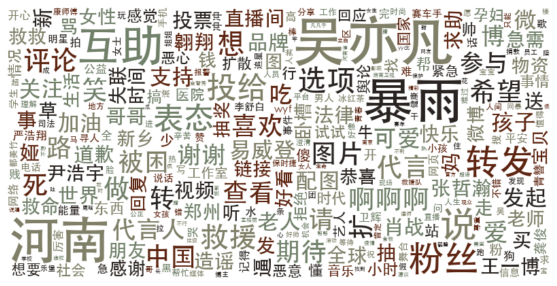

In [115]:
draw_cloud(frequency_dict,0,'general_wc')

In [117]:
ranked_frequency_dict = {k: v for k, v in sorted(frequency_dict.items(), key=lambda item: item[1], reverse=True)}

In [120]:
# translation of the frequency_dict
translated_frequency_dict = {}
for key,value in tqdm(list(ranked_frequency_dict.items())[:1000],position=0):
    translated_key = translate_client.translate(key, target_language='en')['translatedText']
    translated_frequency_dict[translated_key] = value

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.89it/s]


In [ ]:
translated_frequency_dict['Louis Vuitton']= translated_frequency_dict.pop('Easy Vuitton')

In [124]:
translated_frequency_dict

{'Wu Yifan': 54810,
 'rainstorm': 47568,
 'Henan': 47108,
 'Mutual assistance': 34528,
 'Say': 22620,
 'fan': 20966,
 'Forward': 684,
 'Stance': 15526,
 'Vote for': 15376,
 'Options': 14144,
 'Rescue': 990,
 'think': 716,
 'Do': 12068,
 'die': 682,
 'Comment': 11726,
 'smile': 11444,
 'Ah ah ah': 11266,
 'Endorsement': 10608,
 'picture': 3630,
 'hope': 10344,
 'Trapped': 10064,
 'Love': 1150,
 'road': 9934,
 'like': 1708,
 'Check': 9706,
 'China': 9556,
 'expect': 9512,
 'Expand': 9450,
 'change': 9330,
 'Please': 8744,
 'participate': 8236,
 'thanks': 8142,
 'Bo': 8062,
 'Spokesperson': 7876,
 'cute': 7312,
 'eat': 7238,
 'micro': 6688,
 'With pictures': 6420,
 'come on': 6338,
 'Initiate': 6282,
 'child': 740,
 'focus on': 6056,
 'support': 974,
 'elder': 5838,
 'new': 5530,
 'brand': 5458,
 'Ya': 5278,
 'Xiao Zhan': 5228,
 'video': 5202,
 'force': 1022,
 'world': 726,
 'worldwide': 700,
 'law': 5018,
 'purchase': 4966,
 'smoke': 4958,
 'Apologize': 4934,
 'vote': 4906,
 'elder broth

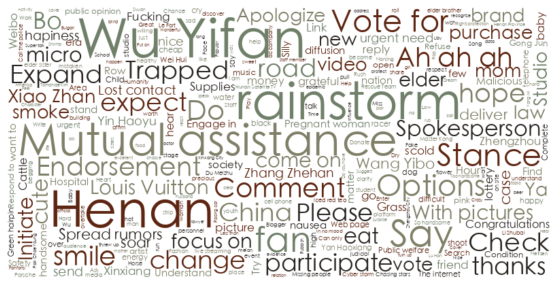

In [125]:
draw_cloud(translated_frequency_dict,0,'translated_general_wc')

# Topic extraction

In [131]:
from gensim import corpora, models, similarities
import gensim

In [129]:
# to decompose each sentence into key words refined by jieba
sentences = []
for i in tqdm(corpus_segregated,position=0):
    sentences.append(cut_words_with_pos(i))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 359585/359585 [06:48<00:00, 879.96it/s]


In [133]:
# bag of words model
dictionary = corpora.Dictionary(sentences)
corpus_topic = [dictionary.doc2bow(sentence) for sentence in sentences]


Exception ignored in: <function tqdm.__del__ at 0x7f53fce90ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tqdm/std.py", line 1152, in __del__
    self.close()
  File "/usr/local/lib/python3.9/dist-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [138]:
# fine-tuning of LDA
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary=dictionary, corpus=corpus_topic):
    """
    Compute u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(3,16),position=0):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus_topic, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [139]:
# two lists contain the record of records and their corresponding coherence value
models, coherence_values = compute_coherence_values()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [09:18<00:00, 42.94s/it]


In [145]:
# use a difference measuring metric
coherence_values2 = []
for i in tqdm(models, position=0):
    coherence_values2.append(CoherenceModel(model=i,texts=sentences,coherence='c_v').get_coherence())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:43<00:00,  3.34s/it]


In [173]:
# save the topics from gensim lda(ranging from topics #3-16)
with open('topic_models.pkl','wb') as f:
    pickle.dump(models,f)

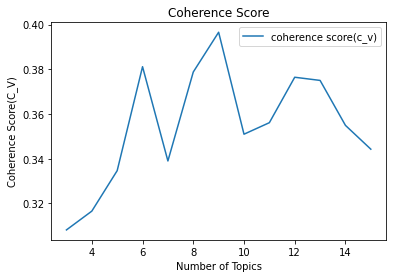

In [171]:
import matplotlib.pyplot as plt
x = range(3,16)
plt.plot(x, coherence_values2,label='coherence score(c_v)')
plt.title('Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score(C_V)')
plt.legend(loc='upper right')
plt.savefig('coherence_score_c_v.png')
plt.show()

In [151]:
# umass
coherence_values

[-4.904677951928467,
 -5.885018573681292,
 -6.621899961055021,
 -6.237991700079785,
 -6.0628889384107385,
 -7.027802423844864,
 -7.468099946513602,
 -7.2914028248962905,
 -7.773724665201658,
 -8.189877680990264,
 -8.590134947020465,
 -9.298977250085239,
 -8.679504630857469]

In [146]:
# c_v
coherence_values2

[0.3081756572294403,
 0.31657740166945636,
 0.3346762558533034,
 0.38117955040359974,
 0.33901713765987307,
 0.37880105545640197,
 0.3965892848149363,
 0.3509886029963149,
 0.3561355828290788,
 0.37646129631804465,
 0.3750445499920488,
 0.35493235582646615,
 0.34428815586162403]

In [140]:
coherence_values

[-4.904677951928467,
 -5.885018573681292,
 -6.621899961055021,
 -6.237991700079785,
 -6.0628889384107385,
 -7.027802423844864,
 -7.468099946513602,
 -7.2914028248962905,
 -7.773724665201658,
 -8.189877680990264,
 -8.590134947020465,
 -9.298977250085239,
 -8.679504630857469]

In [152]:
# after the analysis, the 3rd(6) topic model is the best one
lda_best = models[3]
#
topics_best = []
for topic in lda_best.print_topics(num_topics=6,num_words=20):
    topics_best.append(topic[1])


'\nfor topic in lda_second_best.print_topics(num_topics=6,num_words=20):\n    topics_second_best.append(topic[1])\n'

In [166]:
# the 9th topic model is the probably the best one as well
topics_second_best = []
lda_second_best = models[6]
for topic in lda_second_best.print_topics(num_topics=9,num_words=20):
    topics_second_best.append(topic[1])

In [153]:
# take topics to dictionary
def convert_to_dict(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[i[1].strip().replace('"','')] = float(i[0]) * 1e3
    return frequency_dict

In [154]:
# take topics to a translated dictionary
def convert_to_dict_trans(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[translate_client.translate(i[1].strip().replace('"',''), target_language='en')['translatedText']] = float(i[0]) * 1e3
    return frequency_dict

In [155]:
# draw a word cloud for each sub-topic
def cloud_each_topic(topics:list,model_name:str,trans:bool):
    for i in range(len(topics)):
        topic_words = topics[i]
        if trans:
            freq_dict = convert_to_dict_trans(topic_words)
        else:
            freq_dict = convert_to_dict(topic_words)
        draw_cloud(freq_dict,1,'%s_%d' %(model_name,i))

In [ ]:
# best model to word cloud
cloud_each_topic(topics_best,'best_model',False)

In [ ]:
# best model to word cloud as english
cloud_each_topic(topics_best,'best_model_trans',True)

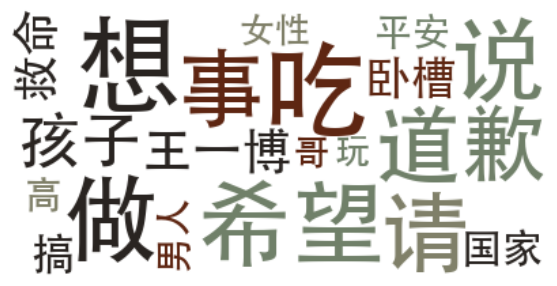

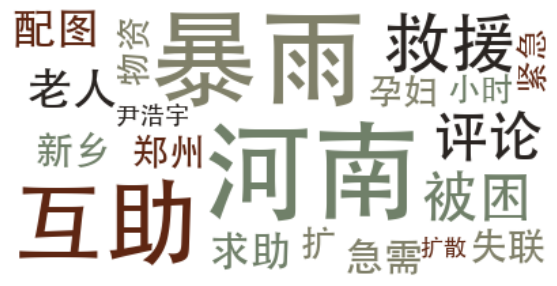

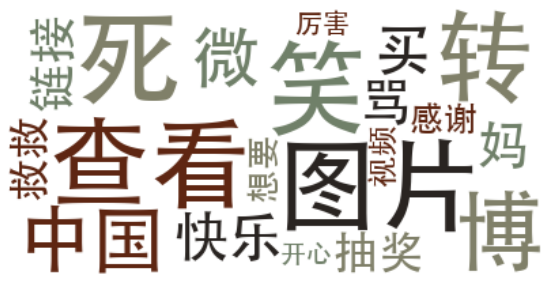

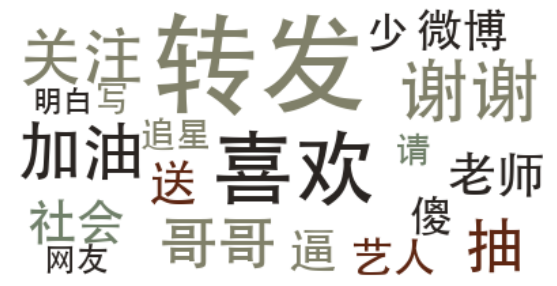

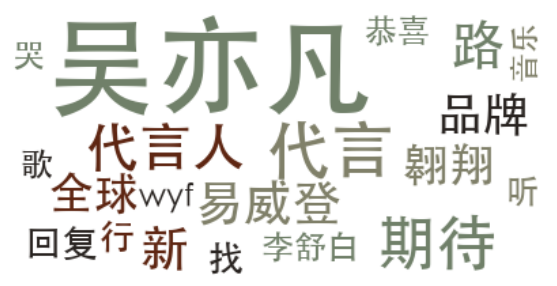

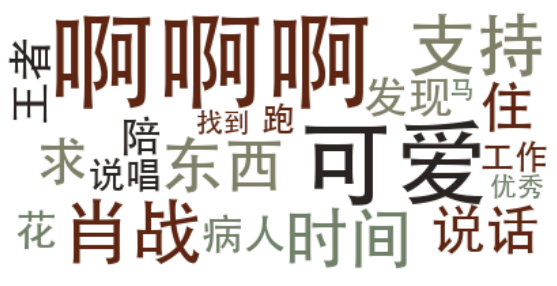

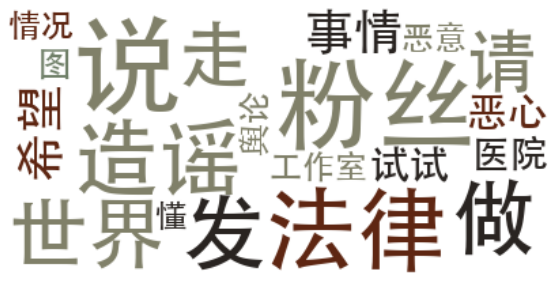

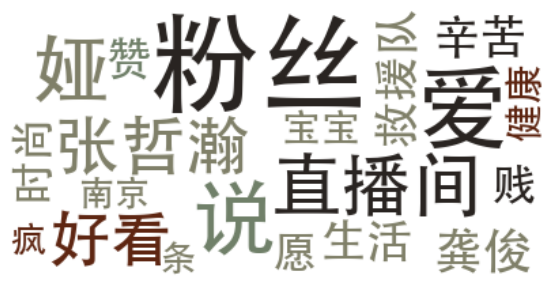

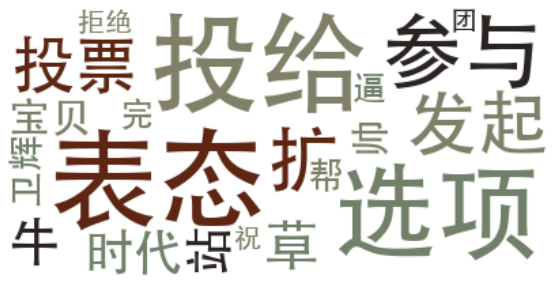

In [167]:
# 2nd best model to word cloud
cloud_each_topic(topics_second_best,'2ndbest_model',False)

In [ ]:
# 2nd best model to word cloud as English
cloud_each_topic(topics_second_best,'2ndbest_model_trans',True)

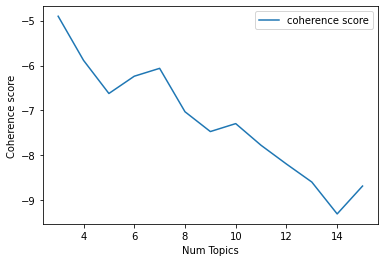

<Figure size 432x288 with 0 Axes>

In [169]:
# plot showing the coherence
x = range(3,16)
plt.plot(x, coherence_values,label='coherence score')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='upper right')
plt.show()
plt.savefig('coherence_score.png')